# Introduction

In this presentation, some toy classification problems are studied. Their common property is that raw features to be used, form inefficient representations, while a bit of feature engineering can result in guaranteed perfect scores. However, for the sake of curiosity, here features are not transformed and it is measured how well Gradient Boosting can predict class labels based on initial representations.

Although the problems that are suggested here may look too artificial and impractical, some useful conclusions are drawn after the experiments.

# General Preparations

In [1]:
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import mpl_toolkits.mplot3d.axes3d as axes3d

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Startup settings can not suppress a warning from `xgboost` and so this is needed.
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import xgboost as xgb

In [2]:
np.random.seed(361)

# Concentric Spheres

This binary classification problem is very simple. There are several concentric (probably, high-dimensional) spheres and each of them is associated with one class only. This means that radius (i.e. distance between a point and the common center of all spheres) is a "golden feature" — a classifier trained only on it can achieve superior accuracy.

Nevertheless, the question is what `xgboost` is able to achieve if it is applied in a naive straightforward fashion without radius computation.

In [3]:
def draw_from_unit_sphere(sample_size, n_dim):
    """
    Draws `sample_size` random samples
    from uniform distribution on
    `n_dim`-dimensional unit sphere.
    
    The idea is to draw samples from an
    isotropic distribution (here, normal
    distribution) and then norm them.
    
    @type sample_size: int
    @type n_dim: int
    @rtype: numpy.ndarray
    """
    normal_sample = np.random.normal(size=(sample_size, n_dim))
    radii = np.sqrt((normal_sample ** 2).sum(axis=1))
    radii = radii.reshape((radii.shape[0], 1))
    return normal_sample / radii

Let us show that the above function works.

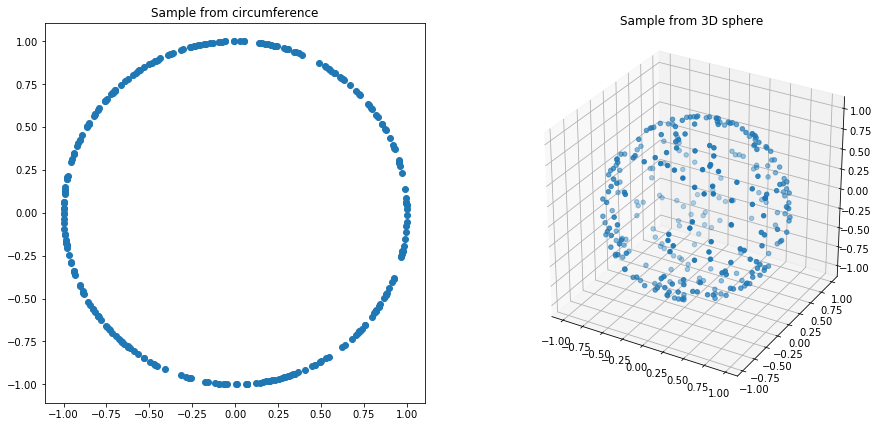

In [4]:
sample_size = 300
circumference = draw_from_unit_sphere(sample_size, 2)
three_d_sphere = draw_from_unit_sphere(sample_size, 3)

fig = plt.figure(figsize=(15, 8))

ax_one = fig.add_subplot(121)
ax_one.scatter(circumference[:, 0], circumference[:, 1])
ax_one.set_aspect('equal')
ax_one.set_title("Sample from circumference")

ax_two = fig.add_subplot(122, projection='3d')
ax_two.scatter(three_d_sphere[:, 0], three_d_sphere[:, 1], three_d_sphere[:, 2])
ax_two.set_aspect('equal')
_ = ax_two.set_title("Sample from 3D sphere", y=1.075)

In [5]:
def draw_from_concentric_spheres(radii, n_dim, samples_per_sphere):
    """
    Draws `sample_per_sphere` samples from
    uniform distribution on a sphere of
    a radius that is in `radii`. Then
    concatenates all such results.
    
    @type radii: list(float)
    @type n_dim: int
    @type samples_per_sphere: int
    @rtype: numpy.ndarray
    """
    spheres = []
    for radius in radii:
        spheres.append(radius * draw_from_unit_sphere(samples_per_sphere, n_dim))
    spheres = np.vstack(spheres)
    return spheres

In [6]:
def synthesize_nested_spheres_dataset(radii_of_positives, radii_of_negatives,
                                      n_dim, samples_per_sphere):
    """
    Creates dataset for a binary classification
    problem, where objects are drawn from
    concentric spheres and distance from the
    origin determines the class of an object.
    
    @type radii_of_positives: list(float)
    @type radii_of_negatives: list(float)
    @type n_dim: int
    @type samples_per_sphere: int
    @rtype: numpy.ndarray
    """
    positives = draw_from_concentric_spheres(radii_of_positives, n_dim,
                                             samples_per_sphere)
    positives = np.hstack((positives, np.ones((positives.shape[0], 1))))
    negatives = draw_from_concentric_spheres(radii_of_negatives, n_dim,
                                             samples_per_sphere)
    negatives = np.hstack((negatives, np.zeros((negatives.shape[0], 1))))
    dataset = np.vstack((positives, negatives))
    return dataset

In [7]:
def evaluate_xgboost_performance(dataset, max_depth):
    """
    Computes ROC-AUC score achieved by
    gradient-boosted trees of depth that
    is not more than `max_depth`.
    
    The reported score is measured on
    hold-out test set and number of
    estimators is determined by
    early stopping.
    
    @type dataset: numpy.ndarray
    @type max_depth: int
    @rtype: float
    """
    # Prepare data.
    X_refit, X_test, y_refit, y_test = \
        train_test_split(dataset[:, :-1], dataset[:, -1],
                         stratify=dataset[:, -1], random_state=361)
    X_train, X_val, y_train, y_val = \
        train_test_split(X_refit, y_refit,
                         stratify=y_refit, random_state=361)
    dm_refit = xgb.DMatrix(X_refit, label=y_refit)
    dm_train = xgb.DMatrix(X_train, label=y_train)
    dm_val = xgb.DMatrix(X_val, label=y_val)
    dm_test = xgb.DMatrix(X_test, label=y_test)
    
    # Set hyperparameters.
    num_rounds = 3000
    hyperparams = {'max_depth': max_depth,
                   'subsample': 0.9,
                   'objective': 'binary:logistic'}
    early_stopping_rounds = 10
    learning_rates = [0.3] * 1000 + [0.2] * 1000 + [0.1] * 1000

    # Train model.
    bst = xgb.train(hyperparams, dm_train, num_rounds,
                    early_stopping_rounds=early_stopping_rounds,
                    evals=[(dm_train, 'train'), (dm_val, 'valid')],
                    learning_rates=learning_rates,
                    verbose_eval=500)
    num_rounds = bst.best_iteration
    learning_rates = learning_rates[:num_rounds]
    bst = xgb.train(hyperparams, dm_refit, num_rounds,
                    evals=[(dm_refit, 'refit')],
                    learning_rates=learning_rates,
                    verbose_eval=500)
    
    # Evaluate performance.
    y_hat = bst.predict(dm_test)
    score = roc_auc_score(y_test, y_hat)
    return score

Settings of the experiment are introduced in the below cell. It is possible to change them in order to see what happens.

In [8]:
positive_radii = [10, 12, 14]
negative_radii = [11, 13]

dims = [2, 3, 4, 5, 6]
base_sizes = [250, 500, 1000, 2000]
curse_adjustment_factor = 4  # Compensate curse of dimensionality.

In [9]:
scores = []
for n_dim, sample_size in product(dims, base_sizes):
    print('\n---')
    print("Dimensionality is {}, base size is {}".format(n_dim, sample_size))
    adjusted_size = (curse_adjustment_factor ** (n_dim - 2)) * sample_size
    dataset = synthesize_nested_spheres_dataset(positive_radii, negative_radii,
                                                n_dim, adjusted_size)
     # Decision stumps work poorly here and so deeper trees are required.
    score = evaluate_xgboost_performance(dataset, max_depth=10)
    scores.append({'n_dim': n_dim, 'sample_size': sample_size, 'score': score})
print('\n')

scores_df = pd.DataFrame(scores)
scores_df


---
Dimensionality is 2, base size is 250
[0]	train-error:0.17094	valid-error:0.251064
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 10 rounds.
Stopping. Best iteration:
[16]	train-error:0.039886	valid-error:0.165957

[0]	refit-error:0.216649

---
Dimensionality is 2, base size is 500
[0]	train-error:0.293741	valid-error:0.309168
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 10 rounds.
Stopping. Best iteration:
[28]	train-error:0.002845	valid-error:0.078891

[0]	refit-error:0.292267

---
Dimensionality is 2, base size is 1000
[0]	train-error:0.244666	valid-error:0.259062
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 10 rounds.
Stopping. Best iteration:
[43]	train-error:0	valid-error:0.009595

[0]	refit-error:0.2752

---

,n_dim,sample_size,score
0,2,250,0.858255
1,2,500,0.989344
2,2,1000,0.998976
3,2,2000,0.999999
4,3,250,0.675104
5,3,500,0.778204
6,3,1000,0.925705
7,3,2000,0.973477
8,4,250,0.615896
9,4,500,0.644249


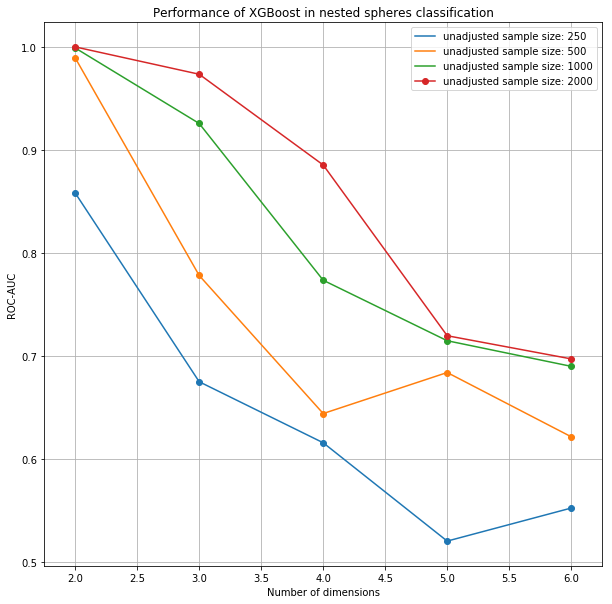

In [10]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
for idx, group in scores_df.groupby(['sample_size']):
    name_for_legend = 'unadjusted sample size: {}'.format(idx)
    group[name_for_legend] = group['score']
    group.plot('n_dim', name_for_legend, ax=ax, marker='o')
ax.set_xlim(min(dims) - 0.25, max(dims) + 0.25)
ax.grid(True)
ax.set_xlabel('Number of dimensions')
ax.set_ylabel('ROC-AUC')
_ = ax.set_title('Performance of XGBoost in nested spheres classification')

Although every value used in the above plot is volatile, some general tendencies can be easily seen. The higher number of dimensions is, the lower ROC-AUC score is. Also the higher number of labelled examples for a particular dimensionality is, the better performance is.

# Nested Surfaces of Revolution with Spheres as Generatrixes

This binary classification problem is a bit more involved. There are several $n$-dimensional nested shapes that are surfaces of revolution constructed by rotation of (hyper)spheres of different radii (called minor radii) along a circumference of a fixed radius (called major radius) centered at the origin. For example, if $n = 3$, the shapes are nested tori.

Again, each shape is associated with one class only. Thus, a "golden feature" is distance between a point and the circumference of revolution. However, like in the previous problem, only coordinates in $n$-dimensional space are used.

In [11]:
def draw_from_surface_of_sphere_revolution(major_radius, minor_radius,
                                           n_dim, sample_size):
    """
    Draws `sample_size` random samples
    from uniform distribution on
    `n_dim`-dimensional surface of
    revolution with hypersphere as
    generatrix.
    
    This hypersphere has radius equal to
    `minor_radius`, while the circumference
    of revolution has radius `major_radius`
    and lies within a linear span of the
    first two basis vectors (denoted as
    x and y respectively).
    
    @type major_radius: float
    @type minor_radius: float
    @type n_dim: int
    @type sample_size: int
    @rtype: numpy.ndarray
    """
    try:
        assert n_dim > 2
    except AssertionError:
        raise ValueError("Number of dimensions must be 3 or greater.")
    try:
        assert major_radius > minor_radius
    except AssertionError:
        raise ValueError("Major radius must be greater than minor radius.")

    revolution_part = draw_from_unit_sphere(sample_size, 2)
    sphere_part = draw_from_unit_sphere(sample_size, n_dim - 1)
    xy_coefficients = major_radius + minor_radius * sphere_part[:, 0]
    xy_coefficients = xy_coefficients.reshape((xy_coefficients.shape[0], 1))
    projection_on_xy =  xy_coefficients * revolution_part
    projection_on_other_axes = minor_radius * sphere_part[:, 1:]
    return np.hstack((projection_on_xy, projection_on_other_axes))

Let us show that the above function works. Why not to draw a sample from torus?

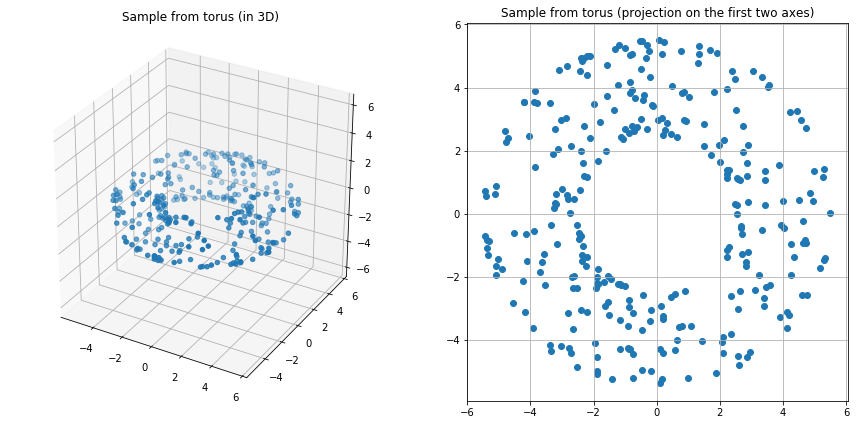

In [12]:
torus = draw_from_surface_of_sphere_revolution(major_radius=4, minor_radius=1.5,
                                               n_dim=3, sample_size=300)

fig = plt.figure(figsize=(15, 8))

ax_one = fig.add_subplot(121, projection='3d')
ax_one.scatter(torus[:, 0], torus[:, 1], torus[:, 2])
ax_one.set_aspect('equal')  # It does not work properly, so below is hack.
ax_one.set_zlim(torus[:, 0].min() - 1, torus[:, 0].max() + 1)
ax_one.set_title("Sample from torus (in 3D)", y=1.075)

ax_two = fig.add_subplot(122)
ax_two.scatter(torus[:, 0], torus[:, 1])
ax_two.set_aspect('equal')
ax_two.grid(True)
_ = ax_two.set_title("Sample from torus (projection on the first two axes)")

In [13]:
def draw_from_nested_surfaces_of_sphere_revolution(major_radius, minor_radii,
                                                   n_dim, samples_per_surface):
    """
    Draws from several uniform
    distributions on nested
    surfaces of revolution. 
    
    @type major_radius: float
    @type minor_radii: list(float)
    @type n_dim: int
    @type samples_per_surface: int
    @rtype: numpy.ndarray
    """
    surfaces = []
    for minor_radius in minor_radii:
        surfaces.append(
            draw_from_surface_of_sphere_revolution(major_radius, minor_radius,
                                                   n_dim, samples_per_surface))
    surfaces = np.vstack(surfaces)
    return surfaces

In [14]:
def synthesize_nested_surfaces_of_revolution(major_radius,
                                             radii_of_positives, radii_of_negatives,
                                             n_dim, samples_per_surface):
    """
    Creates dataset for a binary classification
    problem, where objects are drawn from
    nested surfaces of revolution and distance
    between a point and the circumference of
    revolution determines the class of the point.
    
    @type major_radius: float
    @type radii_of_positives: list(float)
    @type radii_of_negatives: list(float)
    @type n_dim: int
    @type samples_per_surface: int
    @rtype: numpy.ndarray
    """
    positives = draw_from_nested_surfaces_of_sphere_revolution(
        major_radius, radii_of_positives, n_dim, samples_per_surface)
    positives = np.hstack((positives, np.ones((positives.shape[0], 1))))
    negatives = draw_from_nested_surfaces_of_sphere_revolution(
        major_radius, radii_of_negatives, n_dim, samples_per_surface)
    negatives = np.hstack((negatives, np.zeros((negatives.shape[0], 1))))
    dataset = np.vstack((positives, negatives))
    return dataset

Settings of the experiment are introduced in the below cell. It is possible to change them in order to see what happens.

In [15]:
major_radius = 100
positive_radii = [10, 12, 14]
negative_radii = [11, 13]

dims = [3, 4, 5, 6]
base_sizes = [1000, 2000, 4000]
curse_adjustment_factor = 4  # As before, compensate curse of dimensionality.

In [16]:
scores = []
for n_dim, sample_size in product(dims, base_sizes):
    print('\n---')
    print("Dimensionality is {}, base size is {}".format(n_dim, sample_size))
    adjusted_size = (curse_adjustment_factor ** (n_dim - 2)) * sample_size
    dataset = synthesize_nested_surfaces_of_revolution(
        major_radius, positive_radii, negative_radii, n_dim, adjusted_size)
    score = evaluate_xgboost_performance(dataset, max_depth=25)
    scores.append({'n_dim': n_dim, 'sample_size': sample_size, 'score': score})
print('\n')

scores_df = pd.DataFrame(scores)
scores_df


---
Dimensionality is 3, base size is 1000
[0]	train-error:0.252089	valid-error:0.361867
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 10 rounds.
Stopping. Best iteration:
[9]	train-error:0.131911	valid-error:0.3504

[0]	refit-error:0.2434

---
Dimensionality is 3, base size is 2000
[0]	train-error:0.2792	valid-error:0.3604
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 10 rounds.
Stopping. Best iteration:
[11]	train-error:0.161689	valid-error:0.348533

[0]	refit-error:0.277467

---
Dimensionality is 3, base size is 4000
[0]	train-error:0.272978	valid-error:0.3388
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 10 rounds.
Stopping. Best iteration:
[16]	train-error:0.170044	valid-error:0.3184

[0]	refit-error:0.27365

---
D

,n_dim,sample_size,score
0,3,1000,0.672378
1,3,2000,0.697738
2,3,4000,0.732905
3,4,1000,0.682915
4,4,2000,0.704589
5,4,4000,0.736432
6,5,1000,0.683044
7,5,2000,0.708114
8,5,4000,0.745725
9,6,1000,0.686113


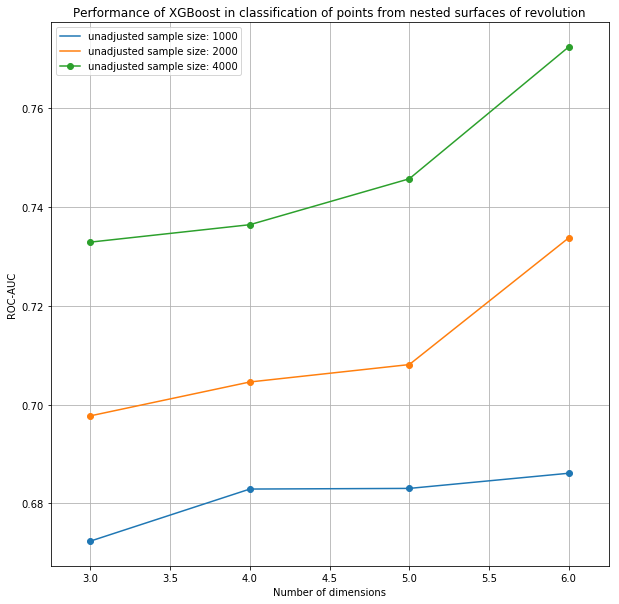

In [17]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
for idx, group in scores_df.groupby(['sample_size']):
    name_for_legend = 'unadjusted sample size: {}'.format(idx)
    group[name_for_legend] = group['score']
    group.plot('n_dim', name_for_legend, ax=ax, marker='o')
ax.set_xlim(min(dims) - 0.25, max(dims) + 0.25)
ax.grid(True)
ax.set_xlabel('Number of dimensions')
ax.set_ylabel('ROC-AUC')
_ = ax.set_title('Performance of XGBoost in classification of points from ' +
                 'nested surfaces of revolution')

Suddenly, the higher the number of dimensions is, the higher ROC-AUC score is. One potential explanation for this is as follows. Probably, Gradient Boosting starves for labelled examples in this problem and `curse_adjustment_factor` is big enough, so it does not only compensate growth of dimensionality, but also provides facilities to train higher capacity algorithms.

Now, let us verify that, indeed, after feature engeneering is applied, the problem becomes trivial.

In [18]:
def generate_golden_feature_for_surfaces_of_revolution(dataset, major_radius):
    """
    For each point from `dataset` computes
    distance between the point and the
    circumference of revolution which has
    radius `major_radius` and lies within
    a span of the first two basis vectors
    (denoted as x and y respectively).
    
    @type dataset: numpy.ndarray
    @type major_radius: float
    @rtype: numpy.ndarray
    """
    norms_of_xy_proj = np.sqrt((dataset[:, :2] ** 2).sum(axis=1))
    norms_of_xy_proj = norms_of_xy_proj.reshape((norms_of_xy_proj.shape[0], 1))
    normed_xy_proj = dataset[:, :2] / norms_of_xy_proj
    nearest_points_from_circumference = major_radius * normed_xy_proj
    other_coordinates = np.zeros((dataset.shape[0], dataset.shape[1] - 3))
    nearest_points_from_circumference = np.hstack(
        (nearest_points_from_circumference, other_coordinates))
    golden_feature = np.sqrt(
        ((dataset[:, :-1] - nearest_points_from_circumference) ** 2).sum(axis=1))
    return golden_feature

In [19]:
golden_feature = generate_golden_feature_for_surfaces_of_revolution(dataset,
                                                                    major_radius)
golden_feature = np.around(golden_feature, decimals=2)
np.unique(golden_feature)

array([ 10.,  11.,  12.,  13.,  14.])

In [20]:
df = pd.DataFrame(np.vstack((golden_feature, dataset[:, -1])).T,
                  columns=['golden_feature', 'target'])
df.groupby(['golden_feature']).agg({'target': [min, max]})

target     
                  min  max
golden_feature            
10.0              1.0  1.0
11.0              0.0  0.0
12.0              1.0  1.0
13.0              0.0  0.0
14.0              1.0  1.0

This means that class label can be reconstructed with 100% accuracy given only the golden feature. Moreover, even single decision tree of depth 4 is able to do it.

# Conclusion

Despite this presentation is related to toy problems of synthetic datasets classification, two meaningful observations can be made:

* There is a heuristic that Gradient Boosting works better with decision stumps rather than with deep decision trees. However, the theory behind this heuristic is sometimes forgotten. Actually, Gradient Boosting requires base estimators that have better performance than random guessing and Gradient Boosting can not significally boost strong classifiers. This means that if decision stumps outperform random guessing, the heuristic is applicable, but otherwise it is misleading. In the considered here problems, decision stumps can not achieve accuracy improvement over random guessing and so learning stucks.

* According to Wolpert's no-free-lunch theorem, there is no machine learning algorithm that can solve every problem excellently. At first glance, the problems from this presentation are the ones that can be solved by Gradient Boosting — there are dense tabular data and number of observations is not small. Nevertheless, inefficient representation does not allow Gradient Boosting to learn true dependency. That being said, data understanding and feature engineering are important stages of data-driven modelling.